In [1]:
import kle
from diffusioneqn import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.set_float32_matmul_precision('high')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
n_trunc = 100
kl = kle.default_KLE(n_trunc, max(100, round(1.5*n_trunc)), device=device)

/home/dannys4/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [140]:
def example_fcn(pts: torch.Tensor, scaling: float = -1.5):
    ret = pts.clone()
    ret[pts > 0.25] = 0.5 - pts[pts > 0.25]
    ret[pts > 0.50] = 0.5*(4*torch.pi*pts[pts > 0.50]).sin()
    ret[pts > 0.75] = 10*(pts[pts > 0.75]-0.75)**2
    return ret*scaling

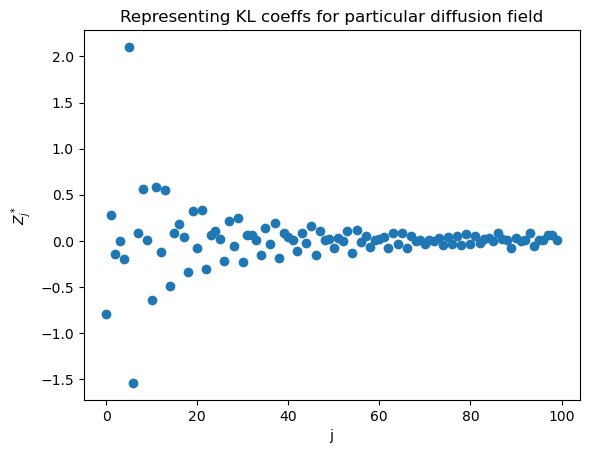

In [141]:
example_coeffs = kl.project_fcn(example_fcn).cpu().detach().numpy()
plt.scatter(np.arange(len(example_coeffs)), example_coeffs)
plt.xlabel("j")
plt.ylabel(r"$Z^*_j$")
plt.title("Representing KL coeffs for particular diffusion field")
plt.show()

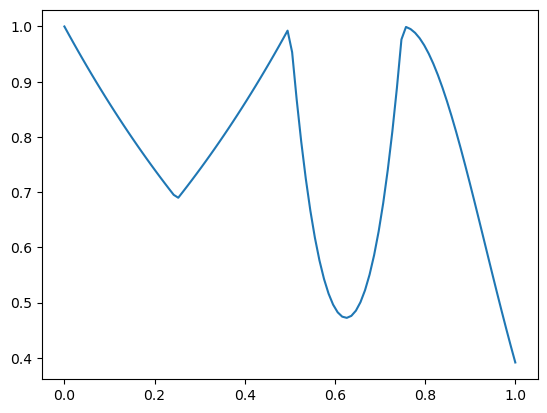

In [142]:
xgrid = torch.linspace(0,1,100)
plt.plot(xgrid, (example_fcn(xgrid)).exp())

In [109]:
def diffusioneqn_batch(k: torch.Tensor, F: float, source: torch.Tensor, rightbc: float):
    """
    Solve 1-D diffusion equation with given diffusivity field k
    and left-hand flux F.
    
    ARGUMENTS: 
        xgrid = vector with equidistant grid points
            F = flux at left-hand boundary, k*du/dx = -F 
       source = source term, either a vector of values at points in xgrid
                or a constant
      rightbc = Dirichlet BC on right-hand boundary
    Domain is given by xgrid (should be [0,1])
    """
    device = k.device
    N, M = k.shape
    h = 1 / (N - 1)
    
    # Prepare source term
    if isinstance(source, (int, float)):
        f = -source * torch.ones((N-1, M), device=device)
    else:
        f = -source[:N-1, :]

    # Build matrix A in batched form
    A = -2 * k[:-1, :] - k[1:, :] - torch.cat((k[:1, :], k[:-2, :]), dim=0)
    A_diag = A / (2 * h * h)

    A_offdiag = (k[:-2, :] + k[1:-1, :]) / (2 * h * h)
    A_matrix = torch.zeros((N-1, N-1, M), device=device)
    
    A_matrix[range(N-1), range(N-1), :] = A_diag
    A_matrix[range(N-2), range(1, N-1), :] = A_offdiag
    A_matrix[range(1, N-1), range(N-2), :] = A_offdiag

    # Adjustments for boundary conditions
    A_matrix[0, 1, :] += k[0, :] / h**2
    f[0, :] -= 2 * F / h
    f[-1, :] -= rightbc * (k[-1, :] + k[-2, :]) / (2 * h**2)

    # Solve for u_internal
    u_internal = torch.linalg.solve(A_matrix.permute(2, 0, 1), f.T).T

    # Concatenate solutions with the boundary condition
    u_solution = torch.cat((u_internal, rightbc * torch.ones((1, M), device=device)), dim=0)

    return u_solution

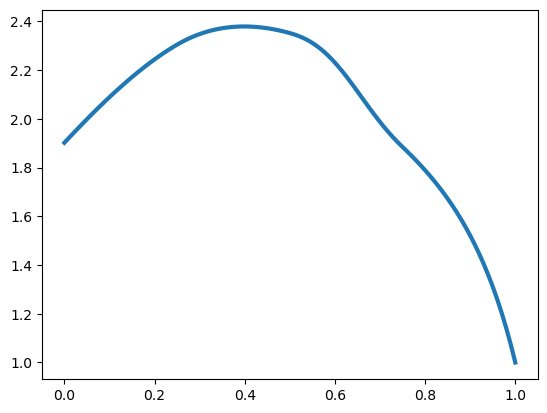

In [143]:
N_ = 100
xgrid_fixed = torch.linspace(0, 1, N_, device=device)
k = torch.exp(example_fcn(xgrid_fixed)).reshape((-1,1))
sol_batch_fixed = diffusioneqn_batch(k, -2, 5, 1)
plt.plot(xgrid_fixed.cpu(), sol_batch_fixed.cpu().flatten(), lw=3)
plt.show()

In [8]:
kl = kle.default_KLE(100, num_quad=150, device=device)

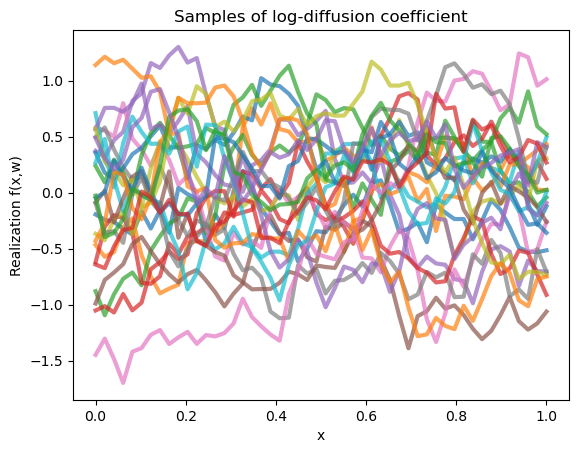

In [170]:
xgrid = torch.linspace(0,1,50,dtype=torch.float64, device=device)
samples, coeff_data = kl(xgrid, M = 10000)
xgrid_cpu = xgrid.cpu().detach().numpy()
samples_cpu = samples.cpu().detach().numpy()
plt.plot(xgrid_cpu, samples_cpu[:,:25], lw=3, alpha=0.7)
plt.title("Samples of log-diffusion coefficient")
plt.xlabel("x")
plt.ylabel("Realization f(x,w)")
plt.savefig("figs/kle/log_diff_samples.png")
plt.show()

In [10]:
sol_samples = diffusioneqn_batch(samples.exp(), -2, 5, 1)

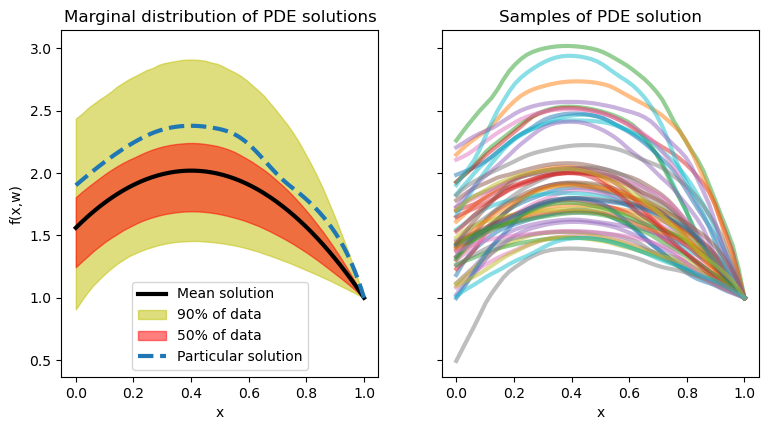

In [190]:
f, (ax2, ax1) = plt.subplots(1,2,sharey=True, figsize=(9,4.5))
ax1.plot(xgrid_cpu, sol_samples[:,:50].cpu(), lw=3, alpha=0.5)
ax1.set_title("Samples of PDE solution")
ax1.set_xlabel("x")

mean_sample = sol_samples.mean(-1).cpu().detach().numpy()
band_sample = sol_samples.quantile(torch.tensor([0.05,0.25,0.75,0.95], device=device), axis=-1).cpu().detach().numpy()

ax2.plot(xgrid_cpu, mean_sample, color='k', lw=3, label="Mean solution")
ax2.fill_between(xgrid_cpu, band_sample[0], band_sample[-1], alpha=0.5, color='y', label="90% of data")
ax2.fill_between(xgrid_cpu, band_sample[1], band_sample[-2], alpha=0.5, color='r', label="50% of data")
ax2.plot(xgrid_fixed.cpu(), sol_batch_fixed.cpu().flatten(), lw=3, ls="dashed", label="Particular solution")
ax2.set_title("Marginal distribution of PDE solutions")
ax2.set_xlabel("x")
ax2.set_ylabel("f(x,w)")
ax2.legend()
f.savefig("figs/kle/solution_samples.png")
f.show()

In [12]:
def even_spacing_obs(sols: torch.Tensor, M_obs: int, noise_level: float):
    N = sols.shape[0]
    interval = N // M_obs
    ret = sols[::interval]
    return ret + noise_level * torch.randn_like(ret)

In [13]:
obs_noise_std = 0.05
M_obs = 5
obs_data = even_spacing_obs(sol_samples, M_obs, obs_noise_std)

In [126]:
N_coeff_trimap = 40
trimap_samples = torch.cat((obs_data, coeff_data[:N_coeff_trimap]), 0).T
trimap_samples.shape

torch.Size([10000, 45])

In [47]:
from utils import *
from triangular_map import *
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from tqdm import tqdm
import time, json

In [49]:
N_quad = 16
quad_pts, quad_wts = clenshaw_curtis_ab(N_quad)
D_in = M_obs + N_coeff_trimap
D_out = N_coeff_trimap
trimap = TriangularMapFactory(D_in, D_out, quad_pts, quad_wts, int_nonlinearity=nn.ReLU, normalization_layer=None, device=device, num_hidden=N_coeff_trimap)
# trimap.compile()
with torch.no_grad():
    test_output = trimap(torch.randn(11,D_in, device=device)), trimap.logdet(torch.randn(7,D_in, device=device))
test_output[0].shape, test_output[1].shape

(torch.Size([11, 40]), torch.Size([7]))

In [30]:
train_loader = DataLoader(trimap_samples, batch_size=64, shuffle=True)

In [149]:
optimizer = optim.Adam(trimap.parameters(), lr=1e-3, weight_decay=1e-5)

previous_epoch_loss = None  # To track the loss difference
losses_file = "data/kle/losses_epoch_{epoch_num}_{time}.json"
metadata_file = "data/kle/metadata_epoch_{epoch_num}_{time}.json"

for epoch in range(81, 100):
  trimap.train(True)
  epoch_start_time = time.time()
  train_loss = 0
  iteration_losses = []

  for X in tqdm(train_loader):
      X = X.to(device, dtype=torch.float32)
      optimizer.zero_grad()
      loss = (0.5*trimap(X)**2).sum() - (trimap.logdet(X)).sum()

      loss.backward()
      train_loss += loss.item()
      iteration_losses.append(loss.item())  # Record the loss for this iteration
      optimizer.step()
  
  epoch_end_time = time.time()
  epoch_loss = train_loss / len(train_loader.dataset)
  epoch_duration = epoch_end_time - epoch_start_time

  loss_difference = epoch_loss - (previous_epoch_loss if previous_epoch_loss is not None else 0)
  previous_epoch_loss = epoch_loss
  with open(losses_file.format(epoch_num=epoch, time=round(time.time())), "w") as f:
      json.dump(iteration_losses, f)

    # Save metadata
  metadata = {
      "epoch": epoch,
      "loss_difference": loss_difference,
      "epoch_duration": epoch_duration,
  }
  with open(metadata_file.format(epoch_num=epoch, time=round(time.time())), "w") as f:
      json.dump(metadata, f)

  # Save model weights
  if epoch % 10 == 0:
      weights_file = f"weights/kle_{epoch}_{round(time.time())}.torch"
      torch.save(trimap.state_dict(), weights_file)

  print('\nEpoch: {} Train Loss: {:.4f} Duration: {:.2f}s'.format(epoch, epoch_loss, epoch_duration))


100%|████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.90it/s]



Epoch: 81 Train Loss: 4.9618 Duration: 9.88s


100%|████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.93it/s]



Epoch: 82 Train Loss: 4.6506 Duration: 9.85s


100%|████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.93it/s]



Epoch: 83 Train Loss: 4.6270 Duration: 9.86s


100%|████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.92it/s]



Epoch: 84 Train Loss: 4.5406 Duration: 9.86s


100%|████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.93it/s]



Epoch: 85 Train Loss: 4.4607 Duration: 9.86s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.58it/s]



Epoch: 86 Train Loss: 4.3908 Duration: 10.77s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.63it/s]



Epoch: 87 Train Loss: 4.3511 Duration: 10.05s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.63it/s]



Epoch: 88 Train Loss: 4.2827 Duration: 10.05s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.63it/s]



Epoch: 89 Train Loss: 4.2390 Duration: 10.05s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.62it/s]



Epoch: 90 Train Loss: 4.1570 Duration: 10.05s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.63it/s]



Epoch: 91 Train Loss: 4.0832 Duration: 10.05s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.62it/s]



Epoch: 92 Train Loss: 4.0229 Duration: 10.05s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.62it/s]



Epoch: 93 Train Loss: 3.9336 Duration: 10.05s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.57it/s]



Epoch: 94 Train Loss: 3.8645 Duration: 10.09s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.50it/s]



Epoch: 95 Train Loss: 3.8173 Duration: 10.13s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.59it/s]



Epoch: 96 Train Loss: 3.7786 Duration: 10.07s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.62it/s]



Epoch: 97 Train Loss: 3.6989 Duration: 10.05s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.63it/s]



Epoch: 98 Train Loss: 3.6254 Duration: 10.05s


100%|████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.65it/s]


Epoch: 99 Train Loss: 3.5741 Duration: 10.03s


In [150]:
torch.save(trimap.state_dict(), "weights/kle_trimap.torch")

In [151]:
new_samp = even_spacing_obs(sol_batch_fixed, M_obs, obs_noise_std).repeat((1,1000)).T
new_samp_coeffs = sample_normal_ref(trimap, 1000, new_samp, device=device)

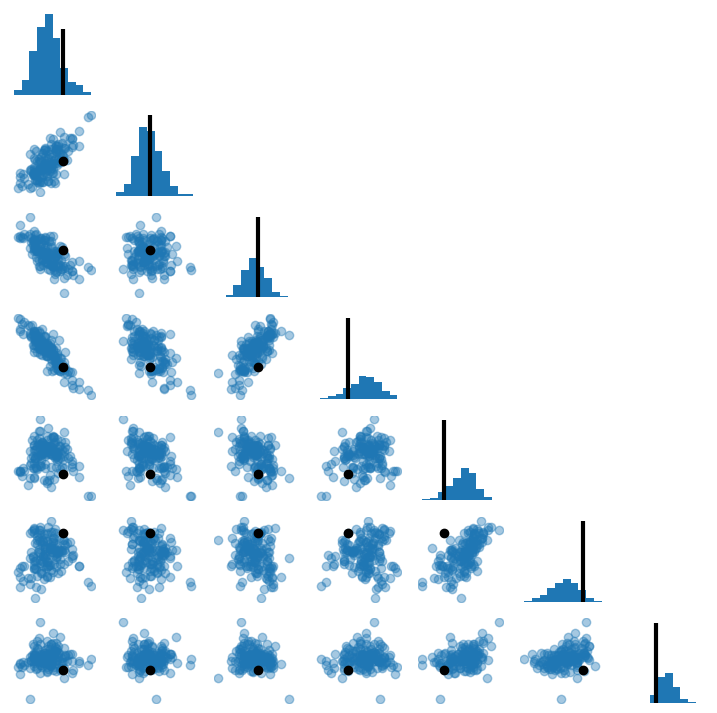

In [152]:
new_samp_coeffs_cpu = new_samp_coeffs.cpu()
d_viz = 7
N_viz = 150
fig, axs = plt.subplots(d_viz, d_viz, sharex='col', figsize=(9.,9.))
# plt.scatter(new_samp_coeffs[:,1].cpu(), new_samp_coeffs[:,2].cpu())
for row in range(d_viz):
    for col in range(d_viz):
        axs[row,col].set_axis_off()
        if col > row:
            continue
        if col == row:
            axs[row,col].hist(new_samp_coeffs_cpu[:,row], density=True)
            axs[row,col].vlines(example_coeffs[row], 0., 1., color='k', lw=3.)
        else:
            axs[row,col].scatter(new_samp_coeffs_cpu[:N_viz,col], new_samp_coeffs_cpu[:N_viz,row], alpha=0.4)
            axs[row,col].scatter(example_coeffs[col], example_coeffs[row], color='k')
fig.savefig("figs/kle/conditional_samples.png")

In [194]:
new_samp_coeffs_aug = torch.cat((new_samp_coeffs, torch.randn((1000,100-N_coeff_trimap), device=device)),-1).to(dtype=torch.float64)
kl_cond_samples = kl(xgrid.to(dtype=torch.float64), new_samp_coeffs_aug.T).cpu()
cond_sol_samples = diffusioneqn_batch(kl_cond_samples.to(torch.float32).exp(), -2, 5, 1)

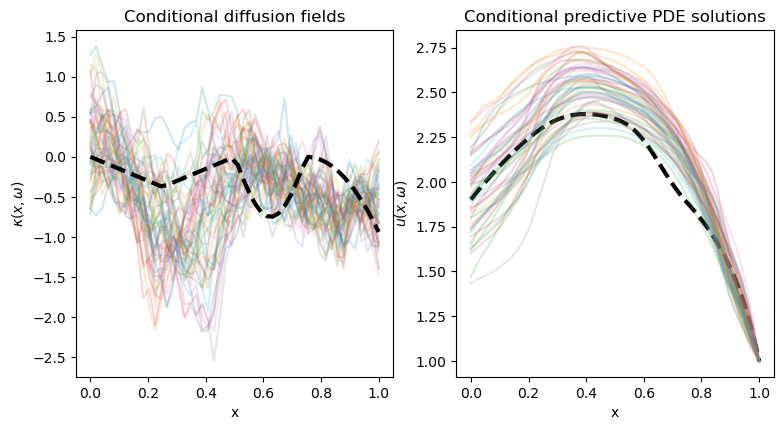

In [199]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9.,4.5))
ax1.plot(xgrid.cpu(), kl_cond_samples.cpu()[:,:50], alpha=0.2)
ax1.plot(xgrid.cpu(), example_fcn(xgrid).cpu(), lw=3, ls='dashed', c='k')
ax1.set_xlabel("x")
ax1.set_ylabel(r"$\kappa(x,\omega)$")
ax1.set_title("Conditional diffusion fields")


ax2.plot(xgrid_fixed.cpu(), sol_batch_fixed.cpu().flatten(), lw=3, ls='dashed', c='k')
ax2.plot(xgrid_cpu, cond_sol_samples[:,:50], alpha=0.2)
ax2.set_xlabel("x")
ax2.set_ylabel(r"$u(x,\omega)$")
ax2.set_title("Conditional predictive PDE solutions")
fig.savefig("figs/kle/conditional_predictive.png")
fig.show()